# Exercise 2: Convolution GAN for MNIST digits

# Giovanni BENEDETTI DA ROSA

This practical session is based on the [DCGAN Pytorch tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).

It was adapted by
* Lucía Bouza
* Bruno Galerne
* Arthur Leclaire

You should complete the code regions marked with ###...###.

## Import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision.utils as vutils
import torch.utils.data as data

import matplotlib.pyplot as plt
import os
import numpy as np
import time

import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)
# !nvidia-smi

# Displaying function
def imshow(img,size=None):
    img = img*0.5 + 0.5     # unnormalize
    if size is not None:
        img = transforms.Resize(size=size, interpolation=transforms.InterpolationMode.NEAREST, antialias=True)(img)
    pil_img = torchvision.transforms.functional.to_pil_image(img)
    display(pil_img)
    # print("Image size (h x w): ",  pil_img.height, "x", pil_img.width)
    return None

Device is cuda


## Download MNIST dataset

Note that we normalize the images between -1 and 1 because during sampling, we have to limit the input space and scaling between -1 and 1 makes it easier to implement it. We discard the last batch so that all batches have the same size.

In [ ]:
batch_size=128
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_set = MNIST(os.getcwd(), train=True, transform=transform, download=True)
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14803349.81it/s]


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 516567.92it/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3456654.64it/s]


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 12172861.83it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



QUESTION: Draw a batch of real images with the train_loader and display them. Use `next` and `iter` to get a batch from `train_loader`.

torch.Size([128, 1, 28, 28])


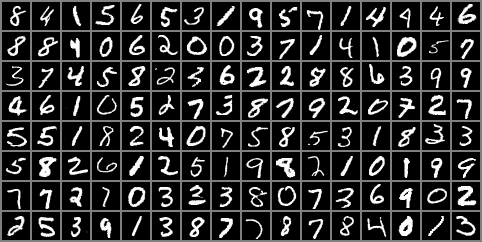

In [ ]:
real,_ = next(iter(train_loader))
print(real.shape)

pil_img = imshow(torchvision.utils.make_grid(real.to('cpu'),nrow=16))

## Generator and Discriminator Models

The architecture of DCGAN is described in the [(Radford et al., 2016)](https://arxiv.org/pdf/1511.06434.pdf)

QUESTION: Examine the architecture of the following generator and discriminator.

In [ ]:
# Size  of generator input
nz = 100

# Size of feature maps in generator and discriminator
ngf, ndf = 64, 64

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels = ngf * 4, out_channels = ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels = ngf, out_channels = 1, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
            # output size. 1 x 28 x 28
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is 1 x 28 x 28
            nn.Conv2d(in_channels = 1, out_channels = ndf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 15 x 15
            nn.Conv2d(in_channels = ndf, out_channels= ndf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(in_channels = ndf * 2, out_channels = ndf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 5 x 5
            nn.Conv2d(in_channels = ndf * 4, out_channels = 1, kernel_size = 4, stride = 2, padding = 1, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# check sizes:
# import torchsummary

# # Create some generator and discriminator
# netG = Generator().to(device)
# netD = Discriminator().to(device)

# torchsummary.summary(netG, input_size=(nz,1,1))
# torchsummary.summary(netD, input_size=(1,28,28))


## Display Samples of the Generator

In [ ]:
# function to display samples of the generator
def show(G,z=None,batch_size=128,nz=100):
  # provide random latent code as option to see evolution
  with torch.no_grad():
    if z==None:
      z = torch.randn(batch_size,nz,1,1).to(device)
    genimages = G(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=16))
    return(pil_img)

## Weight initialization

The DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) mentions that all model weights shall be randomly initialized from a Normal distribution with $\mu=0$ and $\sigma=0.02$. We implement `weights_init` function to reinitialize the weights.

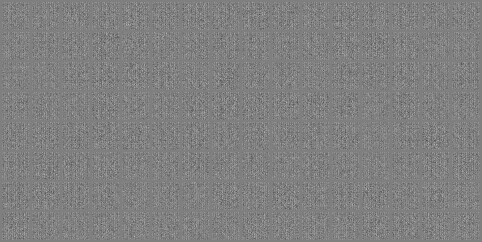

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator and discriminator
G = Generator().to(device)
D = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
G.apply(weights_init);
D.apply(weights_init);

show(G);

<br/><br/><br/><br/><br/>

# Part 1: DCGAN Training with WGAN-GP loss

<br/><br/>
**QUESTION:** Implement WGAN-GP training for MNIST by completing the code in the following cell.
We recall the pseudo-code:

> For each batch of images $x_{\text{real}}$:
>
> **1) Train discriminator:**
> > Generate $z$ a tensor of size $b\times nz\times 1\times 1$ of idd Gaussian variables  
> > Generate  $x_{\text{fake}} = \mathtt{G}(z)$ a set $b$ fake images  
> > Compute the discriminator loss to maximize <br/>
> > Compute the gradient and do an optimizer step for the disciminator parameters  
>
> **2) Train the generator:**
> > Generate $z$ a new tensor of size $b\times nz\times 1\times 1$ of idd Gaussian variables  
> > Compute the generator loss to minimize <br/>
> > Compute the gradient and do an optimizer step for the generator parameters

In [ ]:
def lipconstant(D,x,y):
    b = x.shape[0]
    n = y.shape[0]
    if n > b:
        y = y[0:b, :]
        n = b
    else:
        x = x[0:n, :]
        b = n
    alpha = torch.rand((b, 1, 1, 1), device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_()

    Di = D(interp).view(-1)

    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(
        outputs=Di,
        inputs=interp,
        grad_outputs=gradout,
        create_graph=True,
        retain_graph=True,
    )[0]

    gradients_norm = torch.sqrt(torch.sum(gradients**2, dim=1) + 1e-12)

    return torch.mean(gradients_norm)
def gradient_penalty(D,x,y):
    b = x.shape[0]
    n = y.shape[0]
    # shrink vectors if they are too large
    if n>b:
        y = y[0:b,:]
        n = b
    else:
        x = x[0:n,:]
        b = n
    # compute interpolated points
    alpha = torch.rand((b,1, 1,1),device=device)
    interp = (alpha * y + (1 - alpha) * x)
    interp.requires_grad_()

#     # Calculate interpolation
#     b = x.shape[0]
#     n = y.shape[0]
#     alpha = torch.rand((b,n,1),device=device)
#     interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
#     interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
       create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    epsilon = 1e-12
    gradients_norm = torch.sqrt(torch.sum(gradients**2, dim=1) + epsilon)

    # Return gradient penalty
    return ((gradients_norm - 1) ** 2).mean()


y = next(iter(train_loader))[0].to(device)
x = G(torch.randn(batch_size, nz, 1, 1, device=device)).detach()

print(lipconstant(D,x,y))
print(gradient_penalty(D,x,y))

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


tensor(0.0561, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.8953, device='cuda:0', grad_fn=<MeanBackward0>)


[1/5][0/468][0.9915 s]	Loss_D: -0.2094	Loss_G: 0.3448	Lip(D): 0.0509


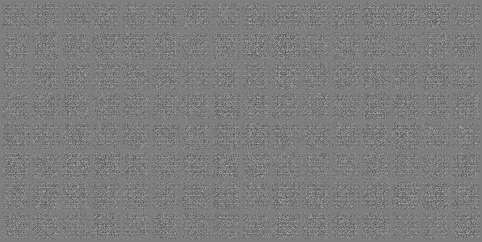

[1/5][100/468][9.4264 s]	Loss_D: -9.3854	Loss_G: 9.1604	Lip(D): 0.2701


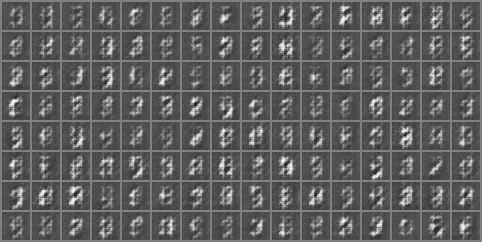

[1/5][200/468][17.7276 s]	Loss_D: -48.4042	Loss_G: 37.9383	Lip(D): 0.3941


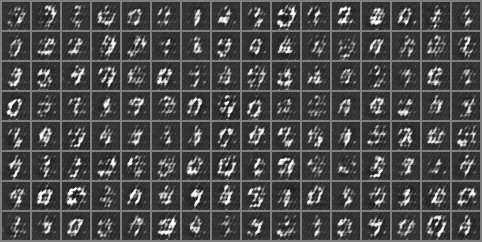

[1/5][300/468][25.7140 s]	Loss_D: -97.9798	Loss_G: 25.1980	Lip(D): 0.6666


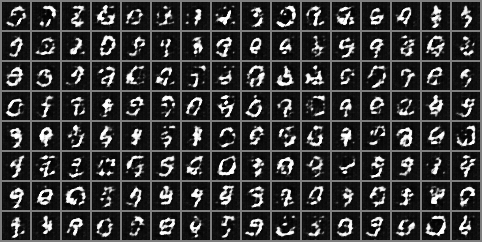

[1/5][400/468][33.7229 s]	Loss_D: -59.6890	Loss_G: 14.7122	Lip(D): 0.4745


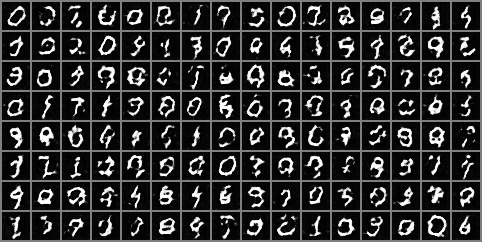

[2/5][0/468][39.4210 s]	Loss_D: -53.9919	Loss_G: 73.5007	Lip(D): 0.4266


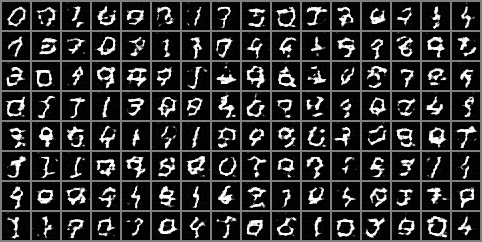

[2/5][100/468][47.5697 s]	Loss_D: -54.4288	Loss_G: 51.9114	Lip(D): 0.4354


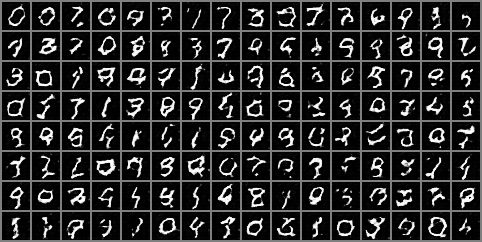

[2/5][200/468][55.7557 s]	Loss_D: -39.9859	Loss_G: 70.1268	Lip(D): 0.7707


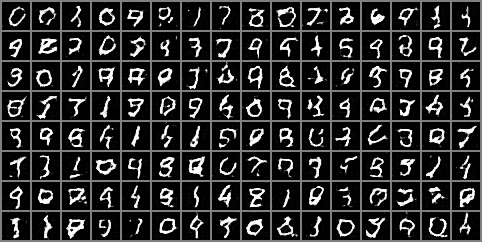

[2/5][300/468][63.8801 s]	Loss_D: -13.6121	Loss_G: 54.6140	Lip(D): 0.6404


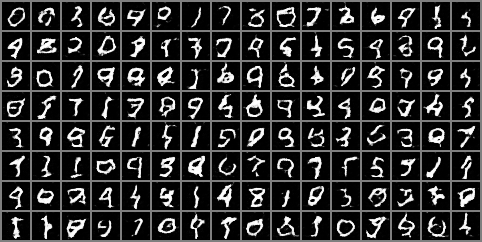

[2/5][400/468][71.8882 s]	Loss_D: -31.2780	Loss_G: 79.8740	Lip(D): 2.1451


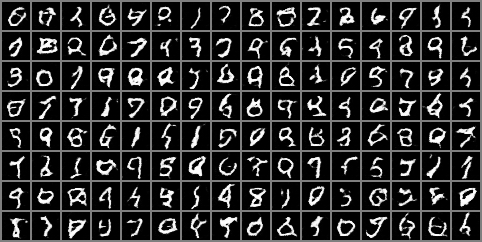

[3/5][0/468][77.5002 s]	Loss_D: -3.4322	Loss_G: 145.3997	Lip(D): 0.5745


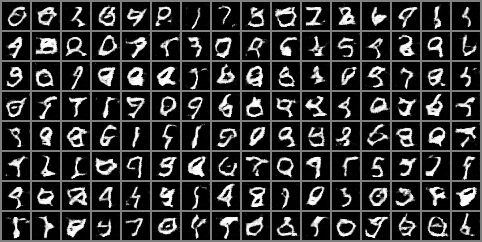

[3/5][100/468][85.4529 s]	Loss_D: -3.4578	Loss_G: 19.7670	Lip(D): 0.9773


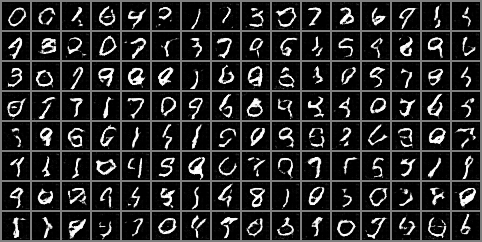

[3/5][200/468][93.4328 s]	Loss_D: -22.0184	Loss_G: 76.2231	Lip(D): 0.9666


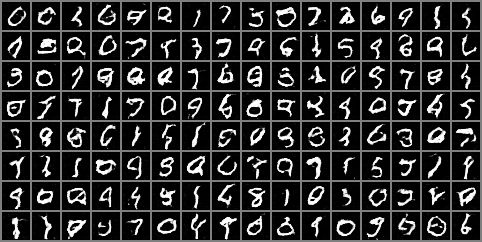

[3/5][300/468][101.4577 s]	Loss_D: -32.8652	Loss_G: 28.6518	Lip(D): 0.9194


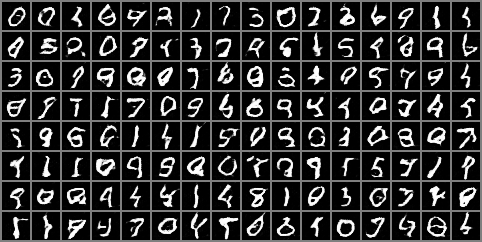

[3/5][400/468][109.5495 s]	Loss_D: -38.8582	Loss_G: 26.8230	Lip(D): 1.1231


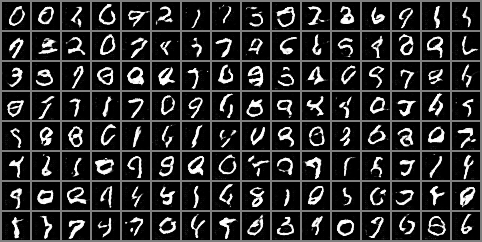

[4/5][0/468][115.1678 s]	Loss_D: -9.6009	Loss_G: 46.0727	Lip(D): 0.8279


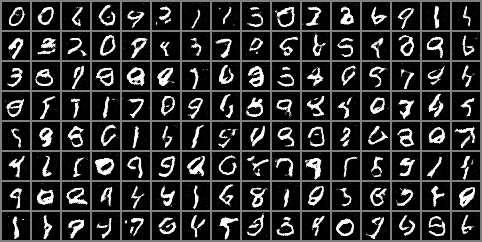

[4/5][100/468][123.1232 s]	Loss_D: -25.3602	Loss_G: -12.6221	Lip(D): 1.9943


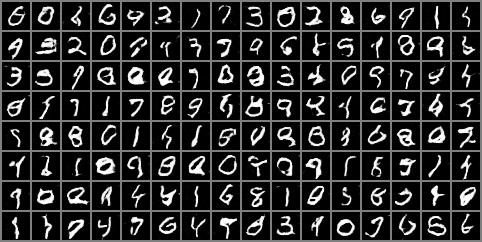

[4/5][200/468][131.3973 s]	Loss_D: -46.7519	Loss_G: 55.2351	Lip(D): 1.1340


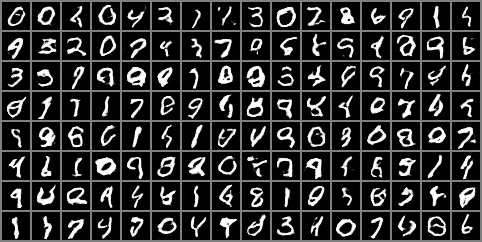

[4/5][300/468][139.4428 s]	Loss_D: -40.1018	Loss_G: 68.8377	Lip(D): 3.0849


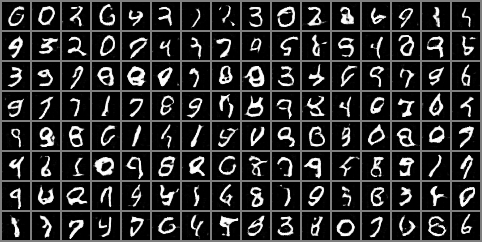

[4/5][400/468][147.4926 s]	Loss_D: -8.1838	Loss_G: 38.5651	Lip(D): 2.8574


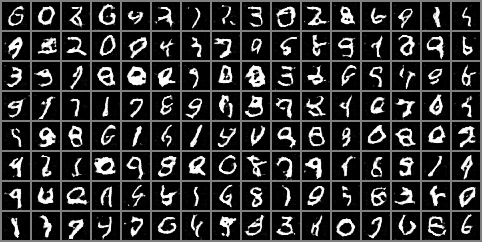

[5/5][0/468][153.2367 s]	Loss_D: -60.8418	Loss_G: 80.5224	Lip(D): 1.9974


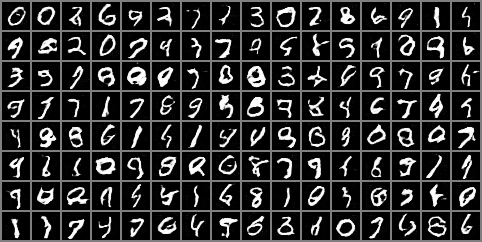

[5/5][100/468][161.1794 s]	Loss_D: -73.0022	Loss_G: 45.8157	Lip(D): 2.7060


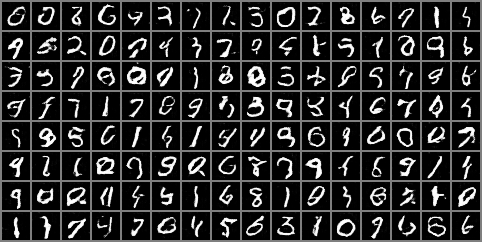

[5/5][200/468][169.2233 s]	Loss_D: -31.4476	Loss_G: -46.6263	Lip(D): 2.3890


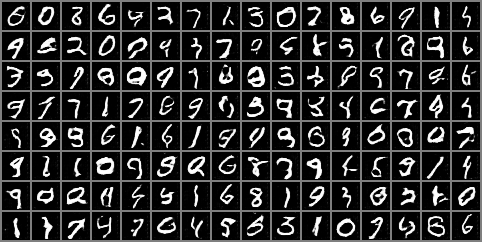

[5/5][300/468][177.2060 s]	Loss_D: 9.1451	Loss_G: -26.2633	Lip(D): 2.1139


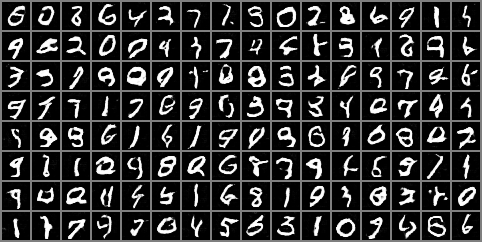

[5/5][400/468][185.1929 s]	Loss_D: -2.3950	Loss_G: 101.6140	Lip(D): 1.6912


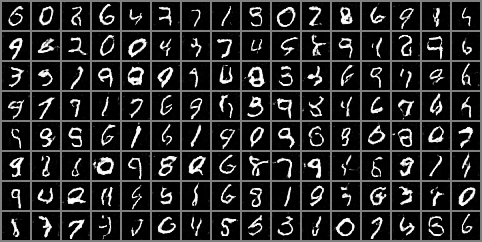

Total learning time =  190.64048290252686


<All keys matched successfully>

In [ ]:
torch.manual_seed(1)  # initialize random seed for reproducibility

num_epochs = 5
log_every = 100
gpw = 0.1

G = Generator().to(device)
D = Discriminator().to(device)
G.apply(weights_init);
D.apply(weights_init);

optimD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

zviz = torch.randn(batch_size,nz,1,1).to(device)

t0 = time.time()
for epoch in range(num_epochs):
    # For each batch in the train_loader
    for i, batch in enumerate(train_loader, 0):

        ############################
        # Batchs of real and fake images
        real = batch[0].to(device)
        fake = G(torch.randn(batch_size, nz, 1, 1, device=device))
        faked = fake.detach()

        ############################
        # Update D network
        optimD.zero_grad()
        Dloss = (
            torch.mean(D(faked))
            + gpw * gradient_penalty(D, faked, real)
            - torch.mean(D(real))
        )
        Dloss.backward()
        optimD.step()

        ############################
        # Update G network
        optimG.zero_grad()
        Gloss = torch.mean(-D(fake))
        Gloss.backward()
        optimG.step()

        ############################
        # Display training stats and visualize
        if i % log_every == 0:
            print('[%d/%d][%d/%d][%.4f s]\tLoss_D: %.4f\tLoss_G: %.4f\tLip(D): %.4f'
                  % (epoch+1, num_epochs, i, len(train_loader), time.time()-t0, Dloss.item(), Gloss.item(),lipconstant(D,real,faked)))
            show(G,zviz)

print('Total learning time = ',time.time()-t0)

# Save final generator in a variable for later use
wgan = Generator()
wgan.load_state_dict(G.state_dict())


In [ ]:
# Save final generator for later use
torch.save(G.state_dict(), 'wgan.pt')
wgan = Generator()
wgan.load_state_dict(G.state_dict())


<All keys matched successfully>

<br/><br/><br/><br/><br/>

# Part 2 BONUS: Let's play with the Generator

## Interpolation in latent space:

**QUESTION:**
Generate 2 sets of 10 latent variable $z_0$ and $z_1$ and display the generated images by the latent variables:
$$
z_\alpha = (1-\alpha) z_0 + \alpha z_1
$$
for $\alpha$ varying between $0$ and $1$.

Display all the images in a grid of height 10 and width 20 images.

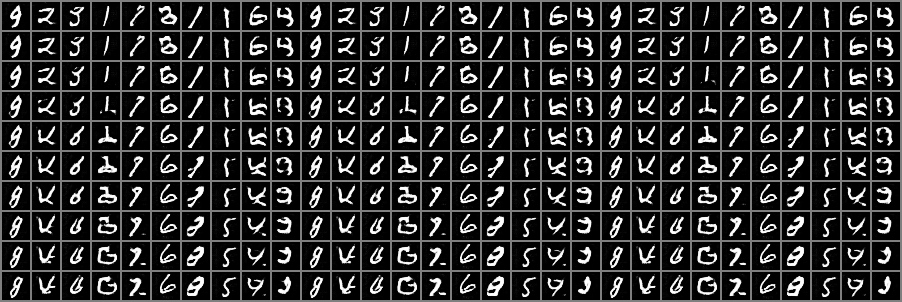

In [ ]:
# You may load a trained generator from a file
# G = Generator().to(device)
# G.load_state_dict(torch.load('wgan_epoch100.pt'))
# G.eval();  # Turn generator in evaluation mode to fix BatchNorm layers

minib = 10
nk = 30

z0 = torch.randn(minib, nz, 1, 1, device=device)
z1 = torch.randn(minib, nz, 1, 1, device=device)

genimages = torch.zeros((minib*nk,1,28,28))
for k in np.arange(nk):
  alpha = k / (nk - 1)
  z_alpha = (1 - alpha) * z0 + alpha * z1
  gen_batch = G(z_alpha)
  genimages[k * minib : (k + 1) * minib] = gen_batch


pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=nk))

## Nearest Neighbor in the Dataset

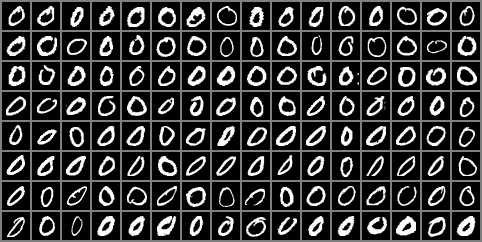

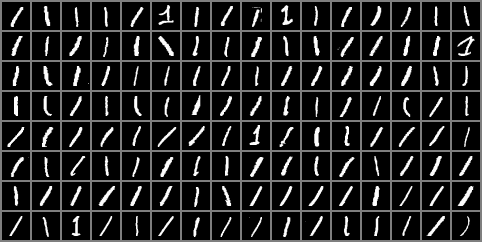

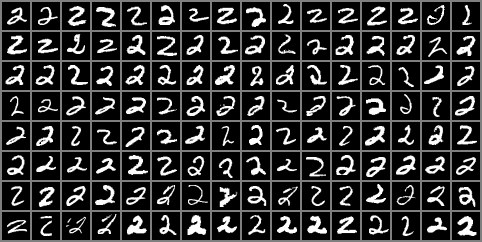

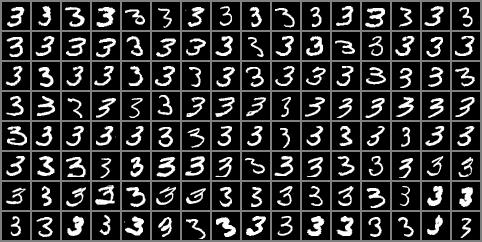

In [ ]:
# load all the database
train_loader_all = data.DataLoader(train_set, batch_size=60000, shuffle=False, num_workers=2, drop_last=True)
y,labels = next(iter(train_loader_all))

realzeros = y[labels==0]
realones = y[labels==1]
realtwos = y[labels==2]
realthrees = y[labels==3]
imshow(torchvision.utils.make_grid(realzeros[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realones[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realtwos[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realthrees[0:128,:,:,:].to('cpu'),nrow=16));

**QUESTION:** For several samples of the generative model, compute the nearest neighbors in the whole dataset.

Display the samples and their nearest neighbor side by side.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(


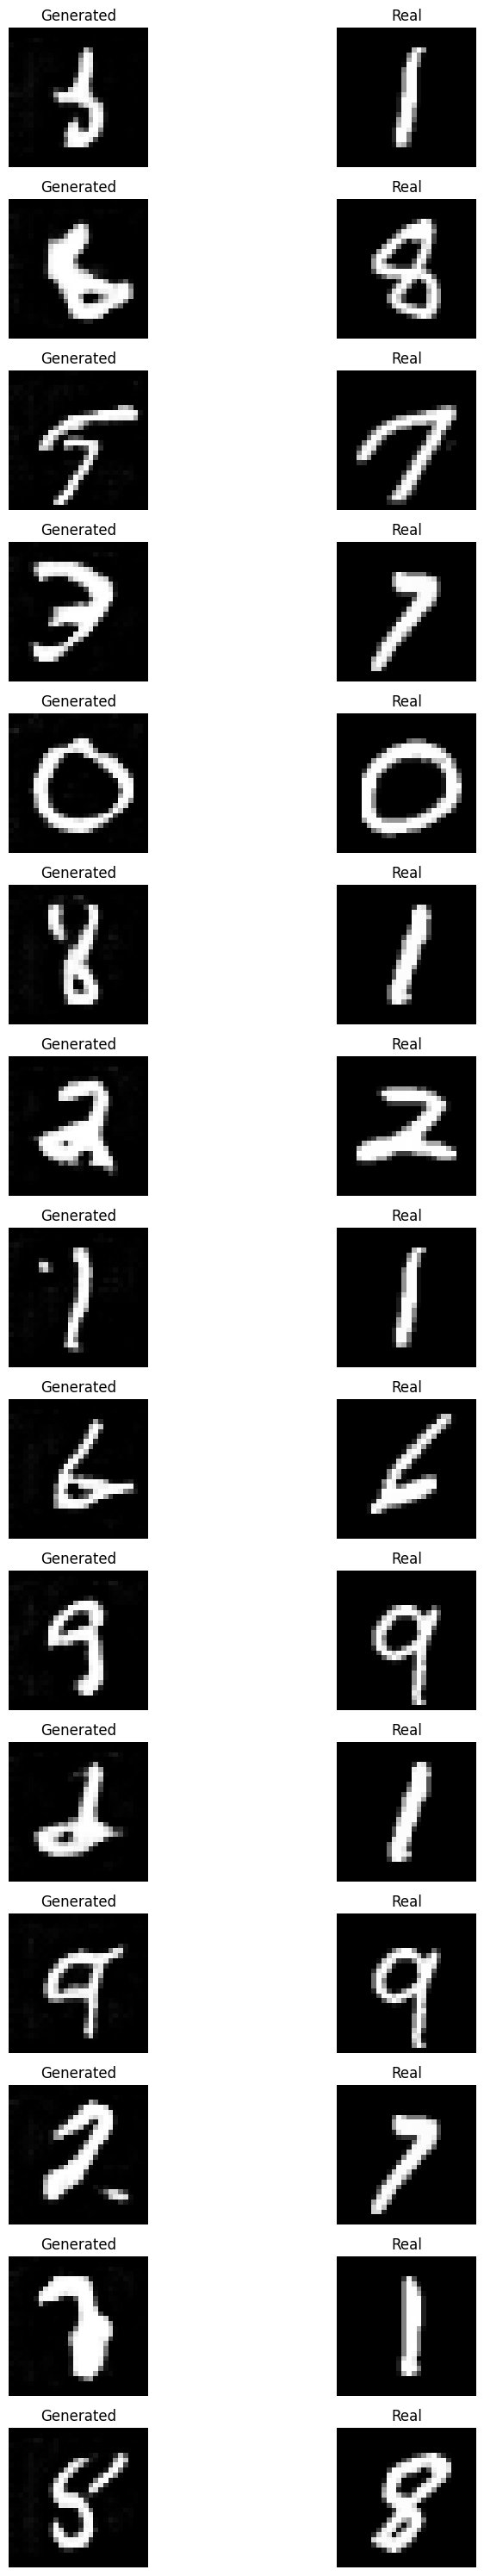

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin

num = 15
generated_samples = G(torch.randn(num, nz, 1, 1, device=device)).detach().cpu()

# Retrieve a batch of real images
y = next(iter(train_loader))[0]


generated_samples = generated_samples.view(num, -1)  # Flatten generated images
y = y.view(y.size(0), -1)  # Flatten real images


nearest_indices = pairwise_distances_argmin(X=generated_samples, Y=y, metric="euclidean")


fig, axs = plt.subplots(num, 2, figsize=(10, 2 * num))  # 2 columns and 'num' rows

for i in range(num):

    axs[i, 0].imshow(generated_samples[i].view(28, 28), cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Generated')

    axs[i, 1].imshow(y[nearest_indices[i]].view(28, 28), cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title('Real')

plt.tight_layout()
plt.show()
